# Loans Repayment Classification

In the following notebook I'll try to classify the repayment of loans - Fully paid/Charged off.  
We'll explore the data given [here](https://www.kaggle.com/wordsforthewise/lending-club).

# 0. Imports and data loading

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

random.seed(1337)

sns.set(style='darkgrid')
%matplotlib inline 

In [2]:
# from google.colab import drive
# from os import path, chdir
# ex_dir = path.join('/content', 'drive')
# drive.mount(ex_dir)
# chdir(path.join('drive',
#                 'My Drive', 
#                 'data'))

In order to explore the data properly, I'll subsample the data to just 10k entries.

In [3]:
# !sudo rm accepted_subsample_seed_42.csv

In [4]:
# !pip3.6 install subsample
# !subsample -s 42 -n 500000 accepted_2007_to_2018Q4.csv -r > accepted_subsample_seed_42.csv

In [5]:
acc_df = pd.read_csv('accepted_subsample_seed_42.csv')

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (0,129,130,131,134,135,136,139) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
print(acc_df.shape)

(500000, 151)


# 1. Shallow EDA - Straight to the baseline

We'd like to get a baseline - a very simple model to get a clue about possible performances

In [7]:
pd.set_option('display.max_rows', 500)
acc_df.head().T.sort_index()

,0,1,2,3,4
acc_now_delinq,0,0,0,0,0
acc_open_past_24mths,4,6,6,5,2
addr_state,PA,CO,IL,GA,VA
all_util,34,NaN,65,35,58
annual_inc,55000,145000,63000,64000,68000
annual_inc_joint,NaN,NaN,71000,109100,NaN
application_type,Individual,Individual,Joint App,Joint App,Individual
avg_cur_bal,20701,45558,31617,4937,12002
bc_open_to_buy,1506,228,2737,34153,14431
bc_util,37.2,94.9,55.9,7.7,53.3


First, let's get a look on out label column: loan_status

In [8]:
fully_paid_vals = [status for status in list(acc_df['loan_status'].value_counts().index) if ("fully paid" in status.lower())]
charged_off_vals = [status for status in list(acc_df['loan_status'].value_counts().index) if ("charged off" in status.lower())]
labels_map = {val : 1 for val in fully_paid_vals}
labels_map.update({val : 0 for val in charged_off_vals})
labels_map

{'Fully Paid': 1,
 'Does not meet the credit policy. Status:Fully Paid': 1,
 'Charged Off': 0,
 'Does not meet the credit policy. Status:Charged Off': 0}

To simplify the problem, we'll ignore all the statuses rather than Fully Paid and Charged Off.

In [9]:
acc_df['loan_label'] = acc_df['loan_status'].replace(labels_map)

In [10]:
df = acc_df[acc_df['loan_label'].isin([0,1])]
df['loan_label'].value_counts()

1    238497
0     59428
Name: loan_label, dtype: int64

Let's cut-off all the features that have more than 80% of nulls, and useless columns

In [11]:
df_dropped = df.dropna(axis=1, how='any', thresh=len(df)*0.80).dropna()

In [12]:
df_dropped['loan_label'] = df_dropped['loan_label'].astype(int)

<AxesSubplot:>

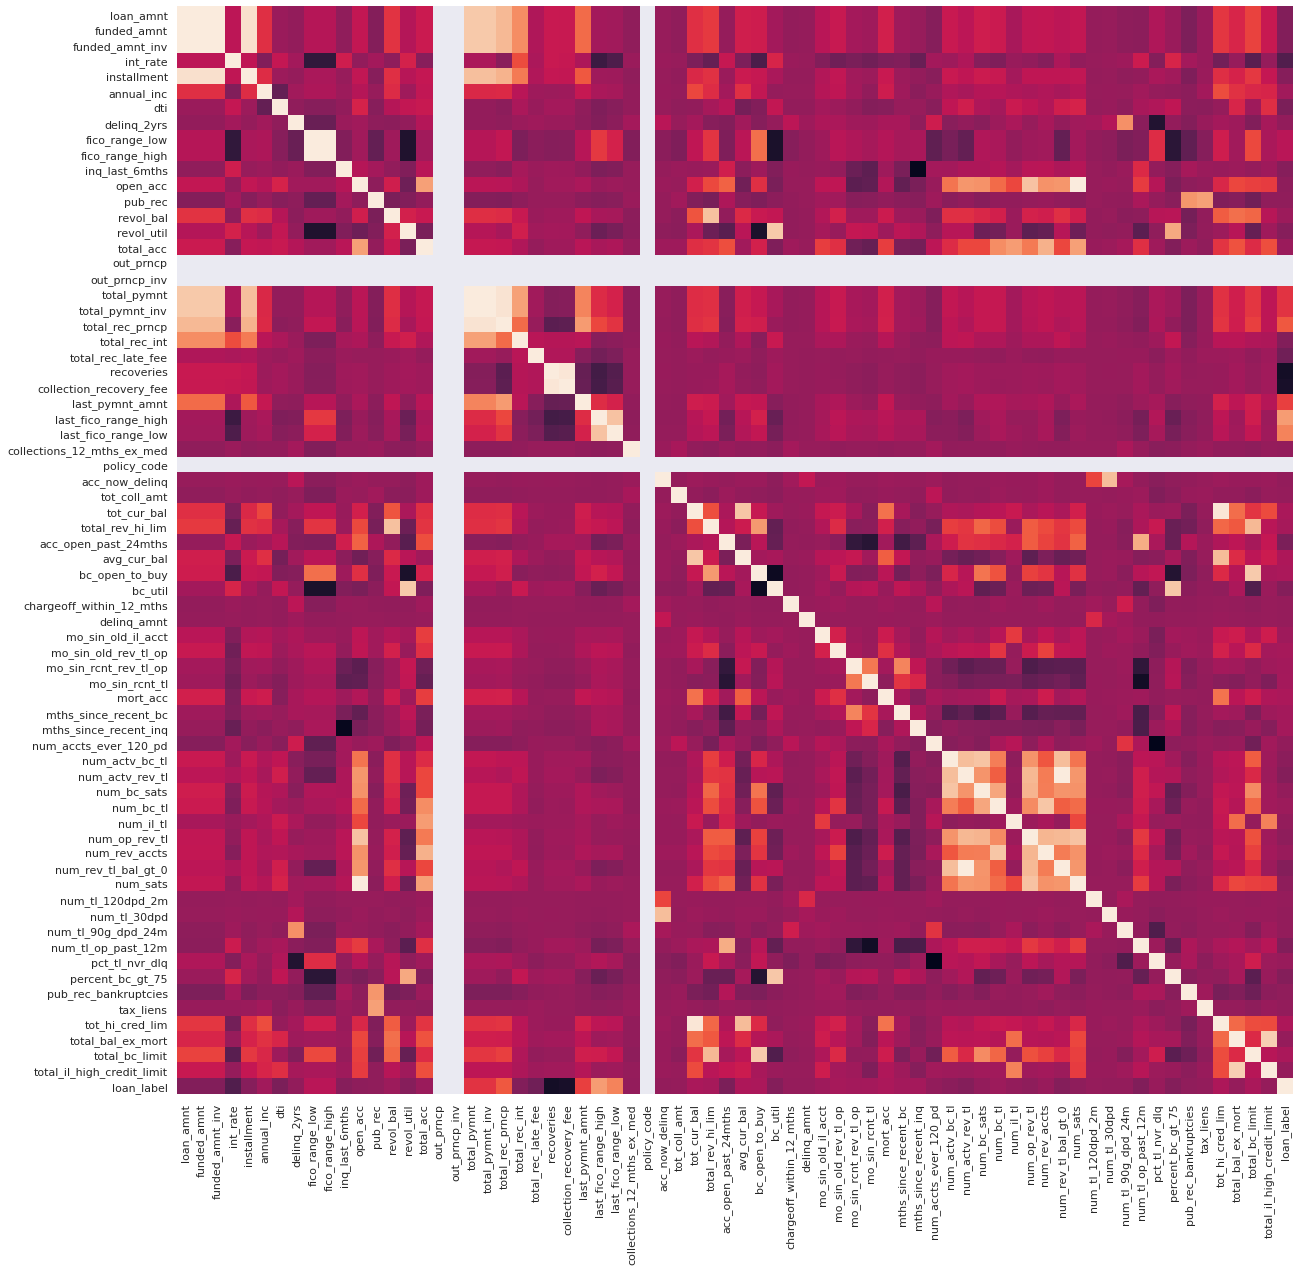

In [13]:
f = plt.figure(figsize=(20,20))
sns.heatmap(df_dropped.sort_index().corr(), cbar=False,xticklabels=True, yticklabels=True)

In [14]:
df_dropped.drop('loan_status', axis=1, inplace=True)

In order to remove useless columns like urls, ids etc., we can eliminate any feature with individual or semi-individual values, of type object.  
We'll set 2 thresholds:
1. feature space's maximal size
2. minimal amount of samples for the most common option in the space

In [15]:
useful_feature = [col for col in df_dropped.loc[:, df_dropped.dtypes == object].columns if 
 (df_dropped[col].value_counts().max() / len(df_dropped) > 0.01) and 
 (len(df_dropped[col].value_counts()) < len(df_dropped) * 0.05)]

In [16]:
useless_features = list(set(df_dropped.loc[:, df_dropped.dtypes == object].columns) - set(useful_feature))

In [17]:
x_baseline = df_dropped.drop(useless_features, axis=1)
x_baseline = x_baseline.dropna(axis=1, thresh=len(x_baseline)*0.8)

Now, let's look at the non-numeric features and see what we can do with them:

In [18]:
x_baseline.loc[:, x_baseline.dtypes == object].head()

,term,grade,sub_grade,emp_length,home_ownership,verification_status,issue_d,pymnt_plan,purpose,title,zip_code,addr_state,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,36 months,C,C4,10+ years,MORTGAGE,Not Verified,Dec-2015,n,debt_consolidation,Debt consolidation,190xx,PA,w,Jan-2019,Mar-2019,Individual,N,Cash,N
1,36 months,C,C1,7 years,MORTGAGE,Source Verified,May-2013,n,credit_card,Clear Credit Card Debt,804xx,CO,f,Aug-2015,Dec-2016,Individual,N,Cash,N
7,36 months,B,B1,10+ years,MORTGAGE,Not Verified,Dec-2015,n,major_purchase,Major purchase,293xx,SC,w,Jan-2017,Mar-2019,Individual,N,Cash,N
8,60 months,D,D2,< 1 year,MORTGAGE,Verified,Nov-2013,n,credit_card,Credit card refinancing,917xx,CA,f,Jun-2015,Aug-2018,Individual,N,Cash,Y
9,36 months,B,B3,10+ years,MORTGAGE,Not Verified,Aug-2013,n,debt_consolidation,Debt payment,322xx,FL,f,Aug-2016,Jan-2019,Individual,N,Cash,N


There are some date features, so we can convert those features to numeric values

In [19]:
x_baseline['months_from_issue_d'] = (pd.to_datetime('today') - pd.to_datetime(x_baseline['issue_d'])).dt.days / 30
x_baseline['months_from_last_pymnt_d'] = (pd.to_datetime('today') - pd.to_datetime(x_baseline['last_pymnt_d'])).dt.days / 30
x_baseline['months_from_last_credit_pull_d'] = (pd.to_datetime('today') - pd.to_datetime(x_baseline['last_credit_pull_d'])).dt.days / 30

In [20]:
date_features = ['issue_d', 'last_pymnt_d', 'last_credit_pull_d']
x_baseline.drop(date_features, axis=1, inplace=True)

In [21]:
x_baseline.loc[:, x_baseline.dtypes == object].head()

,term,grade,sub_grade,emp_length,home_ownership,verification_status,pymnt_plan,purpose,title,zip_code,addr_state,initial_list_status,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,36 months,C,C4,10+ years,MORTGAGE,Not Verified,n,debt_consolidation,Debt consolidation,190xx,PA,w,Individual,N,Cash,N
1,36 months,C,C1,7 years,MORTGAGE,Source Verified,n,credit_card,Clear Credit Card Debt,804xx,CO,f,Individual,N,Cash,N
7,36 months,B,B1,10+ years,MORTGAGE,Not Verified,n,major_purchase,Major purchase,293xx,SC,w,Individual,N,Cash,N
8,60 months,D,D2,< 1 year,MORTGAGE,Verified,n,credit_card,Credit card refinancing,917xx,CA,f,Individual,N,Cash,Y
9,36 months,B,B3,10+ years,MORTGAGE,Not Verified,n,debt_consolidation,Debt payment,322xx,FL,f,Individual,N,Cash,N


The 'zip code' and the 'title' features are may have vast of options, so I'll minimize the amount of options:

In [22]:
common_titles = list(x_baseline['title'].value_counts()[x_baseline['title'].value_counts() > 1000].index)
x_baseline['title'].where(x_baseline['title'].isin(common_titles), 'Other', inplace=True)

In [23]:
common_zipcodes = list((x_baseline['zip_code'].apply(lambda x: x[:3]).value_counts() > 2500).index)
x_baseline['zip_code'].where(x_baseline['zip_code'].isin(common_zipcodes), 'Other', inplace=True)

now let's create dummies for the categorical features:

In [24]:
y_baseline = x_baseline['loan_label']
x_baseline.drop('loan_label', axis=1, inplace=True)

In [25]:
x_baseline_ohe = pd.get_dummies(x_baseline, columns=x_baseline.loc[:, x_baseline.dtypes == object].columns)

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


x_train, x_test, y_train, y_test = train_test_split(x_baseline_ohe.fillna(0), y_baseline.astype(int), test_size=0.33, random_state=42)

In [27]:
model = LogisticRegression().fit(x_train, y_train)
y_pred = model.predict(x_test)

print(classification_report(y_test, y_pred, labels=[0,1], target_names=['Charged Off', 'Fully Paid']))

              precision    recall  f1-score   support

 Charged Off       1.00      0.99      1.00     14296
  Fully Paid       1.00      1.00      1.00     57661

    accuracy                           1.00     71957
   macro avg       1.00      1.00      1.00     71957
weighted avg       1.00      1.00      1.00     71957



/usr/local/lib64/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [28]:
y_pred_train = model.predict(x_train)

print(classification_report(y_train, y_pred_train, labels=[0,1], target_names=['Charged Off', 'Fully Paid']))

              precision    recall  f1-score   support

 Charged Off       1.00      0.99      1.00     28897
  Fully Paid       1.00      1.00      1.00    117196

    accuracy                           1.00    146093
   macro avg       1.00      1.00      1.00    146093
weighted avg       1.00      1.00      1.00    146093



Feature: 0, Score: -0.0022573066716050096
Feature: 1, Score: -0.0022573067518274676
Feature: 2, Score: -0.0022557160781784503
Feature: 3, Score: 1.4267845489517731e-06
Feature: 4, Score: -5.9283099332538195e-05
Feature: 5, Score: 3.6449022212888322e-06
Feature: 6, Score: 4.132767615985678e-06
Feature: 7, Score: 4.724402835869721e-08
Feature: 8, Score: 0.0002768100103035694
Feature: 9, Score: 0.00027838696327085906
Feature: 10, Score: -5.097497684215286e-08
Feature: 11, Score: 2.6254618639083356e-06
Feature: 12, Score: 5.6404779347436656e-08
Feature: 13, Score: -0.00015892803870981928
Feature: 14, Score: 1.577939598748878e-05
Feature: 15, Score: 5.949218801252449e-06
Feature: 16, Score: 0.0
Feature: 17, Score: 0.0
Feature: 18, Score: 0.001265675224108556
Feature: 19, Score: 0.0012660206110579272
Feature: 20, Score: 0.004281128883942611
Feature: 21, Score: -0.0021602095281416525
Feature: 22, Score: -8.876281041490802e-06
Feature: 23, Score: -0.000846367826469167
Feature: 24, Score: -0.00

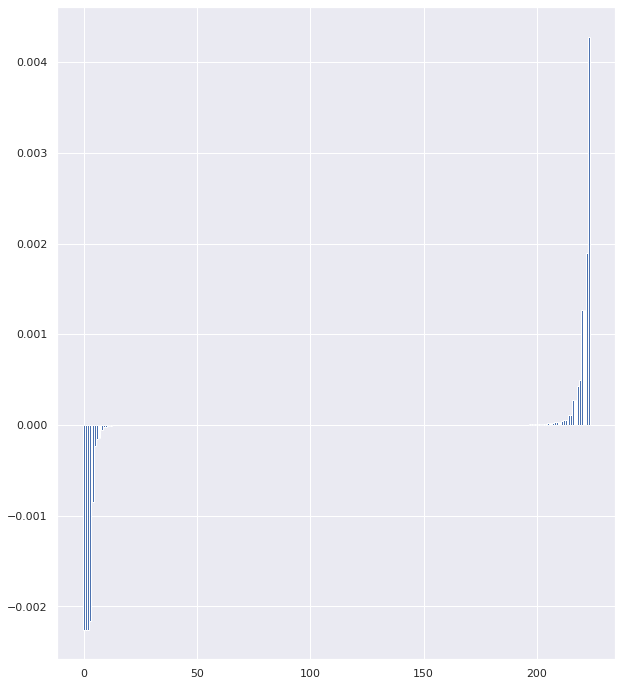

In [29]:
importance = model.coef_
importance = importance.flatten()
# summarize feature importance
for i,v in enumerate(importance):
    print(f'Feature: {i}, Score: {v}')
# plot feature importance
f = plt.figure(figsize=(10,12))
plt.bar([x for x in range(len(importance))], sorted(importance))
plt.show()

In [30]:
[col for col in x_baseline_ohe.columns if "loan" in col]

['loan_amnt']

In [31]:
x_baseline_ohe.iloc[:, importance.argsort()[-5:][::-1]]

,total_rec_prncp,last_pymnt_amnt,total_pymnt_inv,total_pymnt,last_fico_range_low
0,3600.00,122.67,4421.72,4421.723917,560.0
1,7200.00,2359.69,8779.86,8779.859994,685.0
7,20000.00,14618.23,21538.51,21538.508977,670.0
8,7841.74,899.28,28807.32,28807.320000,610.0
9,10000.00,329.91,11879.91,11879.910658,795.0
...,...,...,...,...,...
499988,35000.00,10081.92,41217.50,41217.503953,710.0
499990,25000.00,782.28,28155.92,28155.924066,650.0
499991,30000.00,28300.92,31257.99,31257.988492,760.0
499992,35000.00,24665.21,40635.11,40635.106235,690.0


Further Research:
1. Drop the top features
2. Feature engineering

# 2. Neural Networks

## 2.1 Shallow NN

Now, let's build a network!  
I'll try to reproduce the LogIt's performances

In [32]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision

x_dev, x_test, y_dev, y_test = train_test_split(x_test, y_test, test_size=0.5)
print(x_dev.shape)
print(x_test.shape)

(35978, 224)
(35979, 224)


### 2.1.1 Dataloaders building

In [33]:
class LoansDataset(Dataset):

    def __init__(self, X, y, transform=None):
        data = (X, y)
        self.n_samples = len(data[1])

        self.x_data = torch.from_numpy(data[0])
        self.y_data = torch.from_numpy(data[1]) 
        self.transform = transform

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        sample = self.x_data[index], self.y_data[index]
        if self.transform:
            return self.transform(sample)
        return sample

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [34]:
class Norm:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, sample):
        inputs, targets = sample
        inputs = (inputs - self.mean) / self.std
        return inputs, targets

### 2.1.2 Overfit 

Now, we'll try to overfit the model on 3 samples:

In [35]:
y_train.iloc[[0,1,6]]

431356    1
147690    1
279248    0
Name: loan_label, dtype: int64

In [36]:
x_train.iloc[[0,1,6], [0,13,15]]

,loan_amnt,revol_bal,total_acc
431356,7000.0,9668.0,15.0
147690,7000.0,7071.0,20.0
279248,23725.0,42702.0,36.0


In [37]:
of_train_x = x_train.iloc[[0,1,6]].to_numpy()
of_train_y = y_train.iloc[[0,1,6]].to_numpy()
of_train_dataset = LoansDataset(of_train_x, of_train_y, transform=Norm(of_train_x.mean(), of_train_x.std()))
of_train_loader = torch.utils.data.DataLoader(dataset=of_train_dataset,
                                              batch_size=3,
                                              shuffle=True)

In [38]:
class LogitDNN(nn.Module):
    def __init__(self, input_size):
        super(LogitDNN, self).__init__()
        self.lin = nn.Linear(input_size, 1)
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
#         return self.lin(x)
        return self.activation(self.lin(x))        

In [39]:
model = LogitDNN(x_train.shape[-1])
print(model)

LogitDNN(
  (lin): Linear(in_features=224, out_features=1, bias=True)
  (activation): Sigmoid()
)


In [235]:
learning_rate = 0.001
num_epochs = 30000
# device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
loss = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []
for epoch in range(num_epochs):
    for i, (batch_x, batch_y) in enumerate(of_train_loader):
        batch_x = batch_x.to(device).float()
        batch_y = batch_y.to(device).float()

        y_predicted = model(batch_x)
        y_predicted = y_predicted.reshape(batch_y.shape[0])
        
        optimizer.zero_grad()
        l = loss(y_predicted, batch_y)
#         writer.add_scalar("Loss/train", l, epoch)
        l.backward()
        optimizer.step()
#         for tag, parm in model.named_parameters():
#              writer.add_histogram(tag, parm.grad.data.cpu().numpy(), epoch)

        if (epoch) % 1000 == 0:
            print('epoch ', epoch+1, ' loss = ', l.item())
            losses.append(l.item())

epoch  1 batch  1  loss =  0.7901663184165955
epoch  1001 batch  1  loss =  0.09802272170782089
epoch  2001 batch  1  loss =  0.03176194429397583
epoch  3001 batch  1  loss =  0.01436238270252943
epoch  4001 batch  1  loss =  0.007472468074411154
epoch  5001 batch  1  loss =  0.004169087391346693
epoch  6001 batch  1  loss =  0.002416049363091588
epoch  7001 batch  1  loss =  0.0014308744575828314
epoch  8001 batch  1  loss =  0.0008581813890486956
epoch  9001 batch  1  loss =  0.0005186581984162331
epoch  10001 batch  1  loss =  0.000314889766741544
epoch  11001 batch  1  loss =  0.00019167031859979033
epoch  12001 batch  1  loss =  0.000116892704681959
epoch  13001 batch  1  loss =  7.131000165827572e-05
epoch  14001 batch  1  loss =  4.3591975554591045e-05
epoch  15001 batch  1  loss =  2.6603953301673755e-05
epoch  16001 batch  1  loss =  1.6252355635515414e-05
epoch  17001 batch  1  loss =  9.914296242641285e-06
epoch  18001 batch  1  loss =  6.079695594962686e-06
epoch  19001 bat

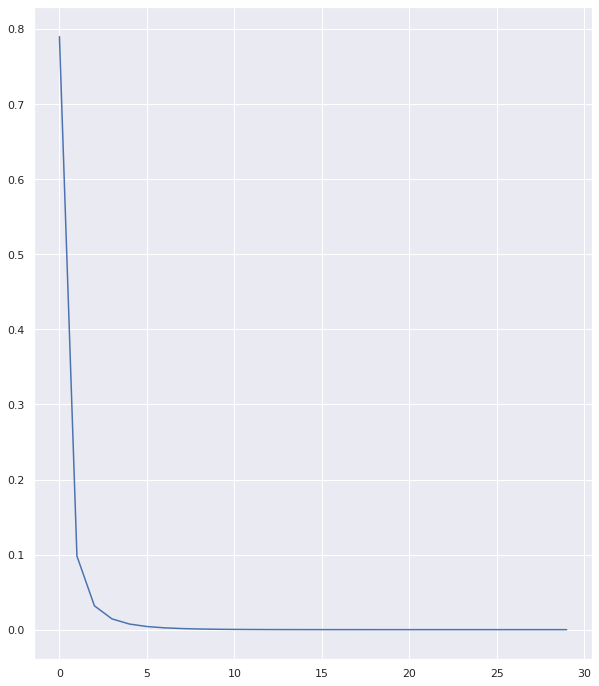

In [236]:
f = plt.figure(figsize=(10,12))
plt.plot(np.arange(len(losses)), losses)

In [237]:
of_train_data = of_train_dataset.x_data.to(device)
of_train_data = of_train_data.reshape(of_train_dataset.x_data.shape[0], -1) / 1.
norm = Norm()
of_train_data, _ = norm((of_train_data, 0))
of_train_labels = of_train_dataset.y_data.to(device)

y_predicted = model(of_train_data.float())

y_predicted = torch.sigmoid(input=y_predicted)
y_predicted_label = (y_predicted > 0.5).squeeze()
accuracy = (y_predicted_label == of_train_labels).sum() / float(y_predicted_label.shape[0])
print(accuracy.item())

1.0


Great! now, let's try on the whole dataset:

### 2.1.3 Full train 

In [40]:
normalizer = Norm(x_train.to_numpy().mean(), x_train.to_numpy().std())

train_dataset = LoansDataset(x_train.to_numpy(), y_train.to_numpy(), transform=normalizer)
dev_dataset = LoansDataset(x_dev.to_numpy(), y_dev.to_numpy(), transform=normalizer)
test_dataset = LoansDataset(x_test.to_numpy(), y_test.to_numpy(), transform=normalizer)

In [41]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

dev_loader = torch.utils.data.DataLoader(dataset=dev_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

Sanity check for the loader:

In [292]:
dataiter = iter(train_loader)
data = dataiter.next()
features, labels = data
print(features, "\n", labels)

tensor([[ 0.2742,  0.2742,  0.2742,  ..., -0.1270, -0.1270, -0.1270],
        [ 0.3544,  0.3544,  0.3544,  ..., -0.1270, -0.1270, -0.1270],
        [ 0.2742,  0.2742,  0.2742,  ..., -0.1270, -0.1270, -0.1270],
        ...,
        [ 0.4347,  0.4347,  0.4347,  ..., -0.1270, -0.1270, -0.1270],
        [ 0.3785,  0.3785,  0.3785,  ..., -0.1270, -0.1270, -0.1270],
        [ 0.4748,  0.4748,  0.4748,  ..., -0.1270, -0.1270, -0.1270]],
       dtype=torch.float64) 
 tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1])


And re-run the train on the whole train:

In [49]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
model = LogitDNN(x_train.shape[-1])
print(model)

LogitDNN(
  (lin): Linear(in_features=224, out_features=1, bias=True)
  (activation): Sigmoid()
)


In [249]:
learning_rate = 0.001
num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.to(device)
losses = []
for epoch in range(num_epochs):
    for i, (batch_x, batch_y) in enumerate(train_loader):
        batch_x = batch_x.to(device).float()
        batch_y = batch_y.to(device).float()
        batch_x = batch_x.reshape(batch_x.shape[0], -1)

        y_predicted = model(batch_x).reshape(-1)

        l = loss(y_predicted, batch_y)
        writer.add_scalar("Loss/train", l, epoch)
        
        l.backward()
        optimizer.step()
        optimizer.zero_grad()

        if (i+1) % 100 == 0:
            print('epoch ', epoch+1, 'batch ', i+1,' loss = ', l.item())
            losses.append(l.item())

epoch  1 batch  100  loss =  0.006956006400287151
epoch  1 batch  200  loss =  0.03711649402976036
epoch  1 batch  300  loss =  0.005796492099761963
epoch  1 batch  400  loss =  0.0035554422065615654
epoch  1 batch  500  loss =  0.004258947446942329
epoch  1 batch  600  loss =  0.003444498870521784
epoch  1 batch  700  loss =  0.0034022959880530834
epoch  1 batch  800  loss =  0.01612481102347374
epoch  1 batch  900  loss =  0.02178819477558136
epoch  1 batch  1000  loss =  0.008216090500354767
epoch  1 batch  1100  loss =  0.005406888201832771
epoch  1 batch  1200  loss =  0.005355301313102245
epoch  1 batch  1300  loss =  0.00415287958458066
epoch  1 batch  1400  loss =  0.004250492434948683
epoch  1 batch  1500  loss =  0.022342583164572716
epoch  1 batch  1600  loss =  0.00370554206892848
epoch  1 batch  1700  loss =  0.045989714562892914
epoch  1 batch  1800  loss =  0.015546473674476147
epoch  1 batch  1900  loss =  0.024090075865387917
epoch  1 batch  2000  loss =  0.02836329862

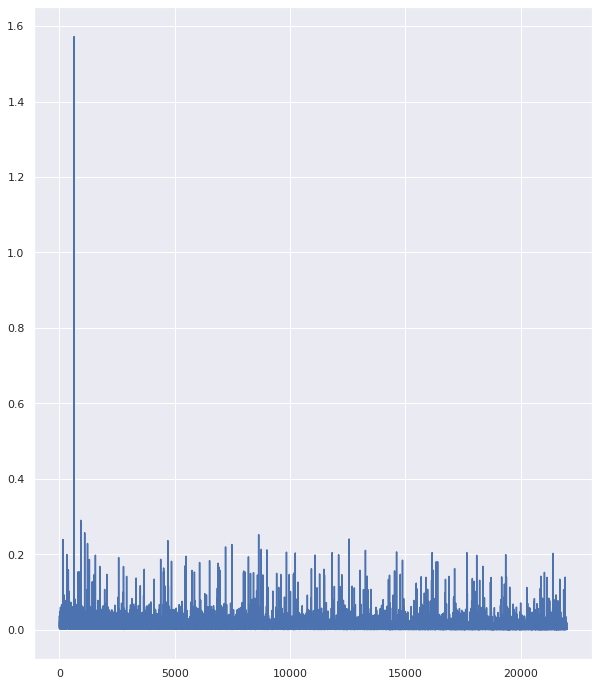

In [250]:
f = plt.figure(figsize=(10,12))
plt.plot(np.arange(len(losses)), losses)

### 2.1.4 Performances

In [42]:
norm = Norm(train_dataset.x_data.mean(), train_dataset.x_data.std())
def eval_model(model, dataset, normalizer):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data, labels = norm((dataset.x_data, dataset.y_data))
    
    data = data.to(device)
    labels = labels.to(device)
    
    data = data.reshape(data.shape[0], -1) / 1.    

    y_predicted = model(data.float())

    y_predicted = torch.sigmoid(input=y_predicted)
    y_predicted_label = (y_predicted > 0.5).squeeze()
    accuracy = (y_predicted_label == labels).sum() / float(y_predicted_label.shape[0])
    return accuracy.item()

In [269]:
print(eval_model(model, train_dataset, norm))

0.9778634309768677


Now on the test:

In [271]:
print(eval_model(model, test_dataset, norm))

0.9779593348503113


## 2.2 2-Layer NN

Now, let's try to outperform the shallow net with another hidden layer:

In [124]:
class LoansClassifier(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LoansClassifier, self).__init__()
        self.lin = nn.Linear(input_size, hidden_size)
        self.activation_i = nn.ReLU()
        self.hidden = nn.Linear(hidden_size, 1)
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        ret = self.lin(x)
        ret = self.activation_i(ret)
        ret = self.hidden(ret)
        return self.activation(ret)

In [108]:
def train_model(model, loader, learning_rate, num_epochs, writer, plot_losses=False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    loss = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.to(device)
    losses = []
    for epoch in range(num_epochs):
        for i, (batch_x, batch_y) in enumerate(loader):
            batch_x = batch_x.to(device).float()
            batch_y = batch_y.to(device).float()
            batch_x = batch_x.reshape(batch_x.shape[0], -1)

            y_predicted = model(batch_x).reshape(-1)

            l = loss(y_predicted, batch_y)
            writer.add_scalar("Loss/train", l, epoch)

            l.backward()
            optimizer.step()
            optimizer.zero_grad()

            if (i+1) % 100 == 0:
                print('epoch ', epoch+1, 'batch ', i+1,' loss = ', l.item())
                losses.append(l.item())
        train_acc = eval_model(model, train_dataset, normalizer)
        writer.add_scalar("Accuracy/train", train_acc, epoch)
    if plot_losses:
        f = plt.figure(figsize=(10,12))
        plt.plot(np.arange(len(losses)), losses)
    else:
        return losses

In [109]:
normalizer = Norm(x_train.to_numpy().mean(), x_train.to_numpy().std())

train_dataset = LoansDataset(x_train.to_numpy(), y_train.to_numpy(), transform=normalizer)
dev_dataset = LoansDataset(x_dev.to_numpy(), y_dev.to_numpy(), transform=normalizer)
test_dataset = LoansDataset(x_test.to_numpy(), y_test.to_numpy(), transform=normalizer)

In [110]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

dev_loader = torch.utils.data.DataLoader(dataset=dev_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

epoch  1 batch  100  loss =  0.3201652765274048
epoch  1 batch  200  loss =  0.17112715542316437
epoch  1 batch  300  loss =  0.10940948128700256
epoch  1 batch  400  loss =  0.09070534259080887
epoch  1 batch  500  loss =  0.06781499087810516
epoch  1 batch  600  loss =  0.07848960161209106
epoch  1 batch  700  loss =  0.08305525779724121
epoch  1 batch  800  loss =  0.11190110445022583
epoch  1 batch  900  loss =  0.0347616970539093
epoch  1 batch  1000  loss =  0.05705205723643303
epoch  1 batch  1100  loss =  0.010180187411606312
epoch  1 batch  1200  loss =  0.019142039120197296
epoch  1 batch  1300  loss =  0.033490829169750214
epoch  1 batch  1400  loss =  0.0305357426404953
epoch  1 batch  1500  loss =  0.05220752954483032
epoch  1 batch  1600  loss =  0.025634411722421646
epoch  1 batch  1700  loss =  0.0030557007994502783
epoch  1 batch  1800  loss =  0.005138092674314976
epoch  1 batch  1900  loss =  0.05809443071484566
epoch  1 batch  2000  loss =  0.01749606430530548
epoch

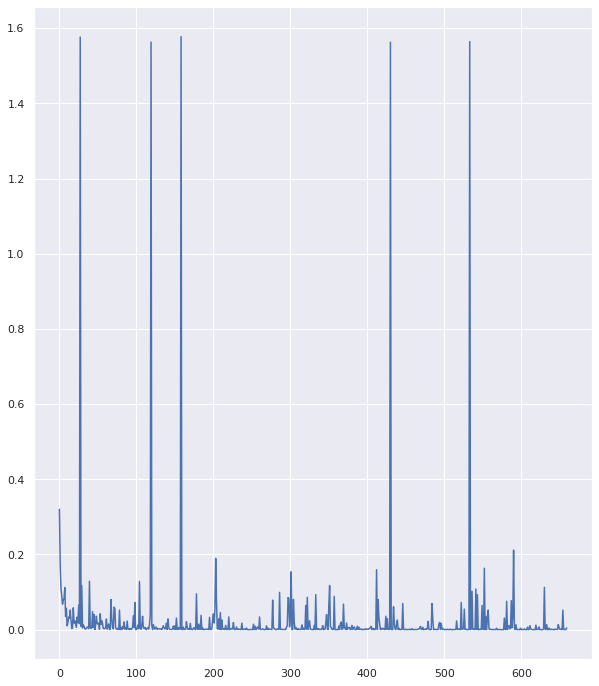

In [149]:
input_size = train_dataset.x_data.shape[-1]
hidden_size = 400
learning_rate = 0.001
num_epochs = 30

writer = SummaryWriter(f'runs/2LDNN_HS{hidden_size}_NE{num_epochs}')
clf = LoansClassifier(input_size, hidden_size)
train_model(clf, train_loader, learning_rate, num_epochs, writer, plot_losses=True)

In [150]:
print(eval_model(clf, train_dataset, normalizer))

0.9860568046569824


In [151]:
print(eval_model(clf, dev_dataset, normalizer))

0.9872978329658508


## 2.3 Deeper NN

Now let's try deeper NN:

In [128]:
class LoansDeepClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LoansDeepClassifier, self).__init__()
        self.lin = nn.Linear(input_size, hidden_size)
        self.activation_i = nn.ReLU()
        self.hidden = nn.Linear(hidden_size, output_size)
        self.activation_o = nn.ReLU()
        self.output = nn.Linear(output_size, 1)
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        ret = self.lin(x)
        ret = self.activation_i(ret)
        ret = self.hidden(ret)
        ret = self.activation_o(ret)
        ret = self.output(ret)
        return self.activation(ret)

In [129]:
normalizer = Norm(x_train.to_numpy().mean(), x_train.to_numpy().std())

train_dataset = LoansDataset(x_train.to_numpy(), y_train.to_numpy(), transform=normalizer)
dev_dataset = LoansDataset(x_dev.to_numpy(), y_dev.to_numpy(), transform=normalizer)
test_dataset = LoansDataset(x_test.to_numpy(), y_test.to_numpy(), transform=normalizer)

In [130]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

dev_loader = torch.utils.data.DataLoader(dataset=dev_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

epoch  1 batch  100  loss =  0.3977821469306946
epoch  1 batch  200  loss =  0.23777402937412262
epoch  1 batch  300  loss =  0.2383369654417038
epoch  1 batch  400  loss =  0.09350118786096573
epoch  1 batch  500  loss =  0.06414325535297394
epoch  1 batch  600  loss =  0.07546377927064896
epoch  1 batch  700  loss =  0.010002710856497288
epoch  1 batch  800  loss =  0.05716298148036003
epoch  1 batch  900  loss =  0.004917563870549202
epoch  1 batch  1000  loss =  0.017607709392905235
epoch  1 batch  1100  loss =  0.0261312834918499
epoch  1 batch  1200  loss =  0.03804367408156395
epoch  1 batch  1300  loss =  0.022357292473316193
epoch  1 batch  1400  loss =  0.007762621156871319
epoch  1 batch  1500  loss =  0.13827252388000488
epoch  1 batch  1600  loss =  0.00992739386856556
epoch  1 batch  1700  loss =  0.00209946115501225
epoch  1 batch  1800  loss =  0.002706204541027546
epoch  1 batch  1900  loss =  0.040260717272758484
epoch  1 batch  2000  loss =  0.0050476365722715855
epo

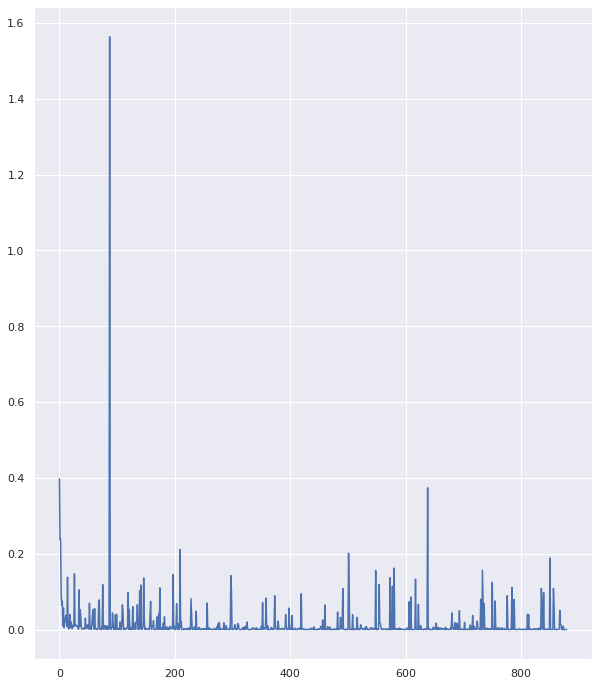

In [152]:
input_size = train_dataset.x_data.shape[-1]
hidden_size = 150
output_size = 30
learning_rate = 0.001
num_epochs = 40

writer = SummaryWriter(f'runs/3LDNN_HS{hidden_size}_OS{output_size}_NE{num_epochs}')
clf = LoansDeepClassifier(input_size, hidden_size, output_size)
train_model(clf, train_loader, learning_rate, num_epochs, writer, plot_losses=True)

In [153]:
print(eval_model(clf, train_dataset, normalizer))

0.9947773218154907


In [154]:
print(eval_model(clf, dev_dataset, normalizer))

0.9953305125236511


# 3. Summary

So, along this course we pass through these steps:
1. We loaded the data
2. We slightly explored the data
3. We decoded non-numeric data into one-hot encoding
4. We maked a baseline model - LogisticRegression which achieve 100% accuracy
5. We traind a shallow net which 97.7% test accuracy
6. We traind deeper network (added 1-2 layers) and outperform the shallow net by achieving 99.5% test accuracy

Along part (6) I traind a couple of models, using different amount of neurons in each layer, with different number of epochs.  
We can review the research process by the following Tensorboard plot:  
![Train losses](Resources/tensorboard.jpeg)  

And the results are:
![Details](Resources/tensorboard_results.jpeg)